## Stochastic chaos Model
$$
y_t = 4 . \varsigma_t . y_{t-1} . (1-y_{t-1}), \varsigma_t \sim U(0,1)
$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# fixed seed
np.random.seed(123)

In [3]:
#Stochastic Chaos Model
def sc(n=500, y0=0.5):
    y = 4 * np.random.uniform(0, 1, size=n)
    y[0] = y0
    for i in range(1, n):
        y[i] *= y[i-1] * (1-y[i-1])
    return y.astype('float32')
y = sc()

In [4]:
df = pd.DataFrame(y, columns=['sc_model'], index=range(500))
#from statsmodels.tsa.stattools import adfuller
#res = sm.tsa.stattools.adfuller(df['sc_model'])
#print('Unit root pvalue: {:f}'.format(res[1]) )

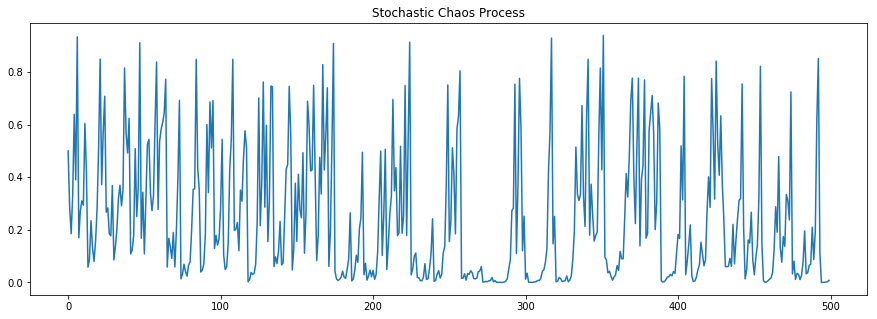

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title('Stochastic Chaos Process')
plt.show()

In [6]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['sc_model'].shift(lag)
#df.head(5)

In [7]:
df = df.dropna(how='any')
#df.head()

In [8]:
Y = df['sc_model'].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [9]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

In [11]:
ols_results = pd.DataFrame(y, columns=['model'])
ols_results['in_sample'] = np.nan
ols_results['out_sample'] = np.nan
ols_in_sample = results.fittedvalues.flatten()
ols_out_sample = results.predict(test_X)

ols_results.loc[5:400, 'in_sample'] = results.fittedvalues.flatten()
ols_results.loc[400:, 'out_sample'] = results.predict(test_X)

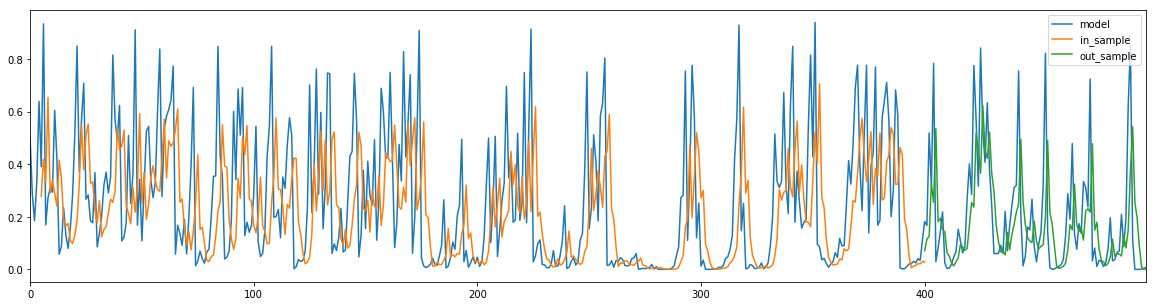

In [12]:
ols_results.plot(figsize=(20, 5));

In [13]:
# calculate root mean squared error and sucess ratio
success_ratio = lambda a, b: np.mean(np.sign(a)==np.sign(b))
ols_des = pd.DataFrame(index=['RMSE', 'R2', 'SR'], columns=['OLS in sample', 'OLS out of sample'])

ols_des.loc['RMSE', 'OLS in sample'] = np.sqrt(mean_squared_error(train_Y, ols_in_sample))
ols_des.loc['RMSE', 'OLS out of sample'] = np.sqrt(mean_squared_error(test_Y, ols_out_sample))
ols_des.loc['R2', 'OLS in sample'] =  r2_score(train_Y, ols_in_sample)
ols_des.loc['R2', 'OLS out of sample'] = r2_score(test_Y, ols_out_sample)

ols_des.loc['SR', 'OLS out of sample'] = success_ratio(test_Y, ols_out_sample)
ols_des

,OLS in sample,OLS out of sample
RMSE,0.22494,0.207552
R2,0.20287,0.110148
SR,NaN,1


## Deep Learning with Keras

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [15]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [16]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [17]:
model = Sequential()
model.add(Dense(lags, input_dim=lags))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mse', optimizer='rmsprop', metrics=[r_coeff, success_ratio])

In [18]:
history = model.fit(train_X, train_Y, 
                    validation_data=(test_X, test_Y),
                    epochs=7000, batch_size=len(train_X), verbose=2,
                   shuffle=False)

Train on 396 samples, validate on 100 samples
Epoch 1/7000
0s - loss: 0.1171 - r_coeff: -8.4428e-01 - success_ratio: 1.0000 - val_loss: 0.1316 - val_r_coeff: -1.7178e+00 - val_success_ratio: 1.0000
Epoch 2/7000
0s - loss: 0.1156 - r_coeff: -8.2137e-01 - success_ratio: 1.0000 - val_loss: 0.1303 - val_r_coeff: -1.6913e+00 - val_success_ratio: 1.0000
Epoch 3/7000
0s - loss: 0.1146 - r_coeff: -8.0506e-01 - success_ratio: 1.0000 - val_loss: 0.1292 - val_r_coeff: -1.6693e+00 - val_success_ratio: 1.0000
Epoch 4/7000
0s - loss: 0.1137 - r_coeff: -7.9160e-01 - success_ratio: 1.0000 - val_loss: 0.1283 - val_r_coeff: -1.6500e+00 - val_success_ratio: 1.0000
Epoch 5/7000
0s - loss: 0.1130 - r_coeff: -7.7979e-01 - success_ratio: 1.0000 - val_loss: 0.1274 - val_r_coeff: -1.6325e+00 - val_success_ratio: 1.0000
Epoch 6/7000
0s - loss: 0.1123 - r_coeff: -7.6907e-01 - success_ratio: 1.0000 - val_loss: 0.1267 - val_r_coeff: -1.6162e+00 - val_success_ratio: 1.0000
Epoch 7/7000
0s - loss: 0.1117 - r_coeff: 

Epoch 158/7000
0s - loss: 0.0703 - r_coeff: -1.0783e-01 - success_ratio: 1.0000 - val_loss: 0.0692 - val_r_coeff: -4.2906e-01 - val_success_ratio: 1.0000
Epoch 159/7000
0s - loss: 0.0702 - r_coeff: -1.0570e-01 - success_ratio: 1.0000 - val_loss: 0.0690 - val_r_coeff: -4.2446e-01 - val_success_ratio: 1.0000
Epoch 160/7000
0s - loss: 0.0701 - r_coeff: -1.0360e-01 - success_ratio: 1.0000 - val_loss: 0.0687 - val_r_coeff: -4.1988e-01 - val_success_ratio: 1.0000
Epoch 161/7000
0s - loss: 0.0699 - r_coeff: -1.0152e-01 - success_ratio: 1.0000 - val_loss: 0.0685 - val_r_coeff: -4.1535e-01 - val_success_ratio: 1.0000
Epoch 162/7000
0s - loss: 0.0698 - r_coeff: -9.9457e-02 - success_ratio: 1.0000 - val_loss: 0.0683 - val_r_coeff: -4.1084e-01 - val_success_ratio: 1.0000
Epoch 163/7000
0s - loss: 0.0697 - r_coeff: -9.7416e-02 - success_ratio: 1.0000 - val_loss: 0.0681 - val_r_coeff: -4.0638e-01 - val_success_ratio: 1.0000
Epoch 164/7000
0s - loss: 0.0695 - r_coeff: -9.5396e-02 - success_ratio: 1.0

0s - loss: 0.0595 - r_coeff: 0.0631 - success_ratio: 1.0000 - val_loss: 0.0494 - val_r_coeff: -2.0814e-02 - val_success_ratio: 1.0000
Epoch 329/7000
0s - loss: 0.0594 - r_coeff: 0.0635 - success_ratio: 1.0000 - val_loss: 0.0494 - val_r_coeff: -2.0262e-02 - val_success_ratio: 1.0000
Epoch 330/7000
0s - loss: 0.0594 - r_coeff: 0.0638 - success_ratio: 1.0000 - val_loss: 0.0494 - val_r_coeff: -1.9728e-02 - val_success_ratio: 1.0000
Epoch 331/7000
0s - loss: 0.0594 - r_coeff: 0.0642 - success_ratio: 1.0000 - val_loss: 0.0493 - val_r_coeff: -1.9210e-02 - val_success_ratio: 1.0000
Epoch 332/7000
0s - loss: 0.0594 - r_coeff: 0.0646 - success_ratio: 1.0000 - val_loss: 0.0493 - val_r_coeff: -1.8708e-02 - val_success_ratio: 1.0000
Epoch 333/7000
0s - loss: 0.0594 - r_coeff: 0.0649 - success_ratio: 1.0000 - val_loss: 0.0493 - val_r_coeff: -1.8219e-02 - val_success_ratio: 1.0000
Epoch 334/7000
0s - loss: 0.0593 - r_coeff: 0.0653 - success_ratio: 1.0000 - val_loss: 0.0493 - val_r_coeff: -1.7745e-02 

0s - loss: 0.0562 - r_coeff: 0.1148 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0261 - val_success_ratio: 1.0000
Epoch 471/7000
0s - loss: 0.0562 - r_coeff: 0.1151 - success_ratio: 1.0000 - val_loss: 0.0472 - val_r_coeff: 0.0258 - val_success_ratio: 1.0000
Epoch 472/7000
0s - loss: 0.0561 - r_coeff: 0.1155 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0267 - val_success_ratio: 1.0000
Epoch 473/7000
0s - loss: 0.0561 - r_coeff: 0.1158 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0264 - val_success_ratio: 1.0000
Epoch 474/7000
0s - loss: 0.0561 - r_coeff: 0.1162 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0274 - val_success_ratio: 1.0000
Epoch 475/7000
0s - loss: 0.0561 - r_coeff: 0.1165 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0270 - val_success_ratio: 1.0000
Epoch 476/7000
0s - loss: 0.0561 - r_coeff: 0.1169 - success_ratio: 1.0000 - val_loss: 0.0471 - val_r_coeff: 0.0280 - val_success_ratio: 1.0000
Epoch 4

0s - loss: 0.0532 - r_coeff: 0.1613 - success_ratio: 1.0000 - val_loss: 0.0452 - val_r_coeff: 0.0662 - val_success_ratio: 1.0000
Epoch 624/7000
0s - loss: 0.0532 - r_coeff: 0.1616 - success_ratio: 1.0000 - val_loss: 0.0452 - val_r_coeff: 0.0671 - val_success_ratio: 1.0000
Epoch 625/7000
0s - loss: 0.0532 - r_coeff: 0.1618 - success_ratio: 1.0000 - val_loss: 0.0452 - val_r_coeff: 0.0667 - val_success_ratio: 1.0000
Epoch 626/7000
0s - loss: 0.0532 - r_coeff: 0.1621 - success_ratio: 1.0000 - val_loss: 0.0451 - val_r_coeff: 0.0675 - val_success_ratio: 1.0000
Epoch 627/7000
0s - loss: 0.0532 - r_coeff: 0.1623 - success_ratio: 1.0000 - val_loss: 0.0452 - val_r_coeff: 0.0671 - val_success_ratio: 1.0000
Epoch 628/7000
0s - loss: 0.0532 - r_coeff: 0.1626 - success_ratio: 1.0000 - val_loss: 0.0451 - val_r_coeff: 0.0679 - val_success_ratio: 1.0000
Epoch 629/7000
0s - loss: 0.0531 - r_coeff: 0.1628 - success_ratio: 1.0000 - val_loss: 0.0451 - val_r_coeff: 0.0675 - val_success_ratio: 1.0000
Epoch 6

0s - loss: 0.0511 - r_coeff: 0.1956 - success_ratio: 1.0000 - val_loss: 0.0437 - val_r_coeff: 0.0978 - val_success_ratio: 1.0000
Epoch 793/7000
0s - loss: 0.0511 - r_coeff: 0.1957 - success_ratio: 1.0000 - val_loss: 0.0437 - val_r_coeff: 0.0976 - val_success_ratio: 1.0000
Epoch 794/7000
0s - loss: 0.0510 - r_coeff: 0.1959 - success_ratio: 1.0000 - val_loss: 0.0437 - val_r_coeff: 0.0981 - val_success_ratio: 1.0000
Epoch 795/7000
0s - loss: 0.0510 - r_coeff: 0.1961 - success_ratio: 1.0000 - val_loss: 0.0437 - val_r_coeff: 0.0979 - val_success_ratio: 1.0000
Epoch 796/7000
0s - loss: 0.0510 - r_coeff: 0.1962 - success_ratio: 1.0000 - val_loss: 0.0436 - val_r_coeff: 0.0985 - val_success_ratio: 1.0000
Epoch 797/7000
0s - loss: 0.0510 - r_coeff: 0.1964 - success_ratio: 1.0000 - val_loss: 0.0437 - val_r_coeff: 0.0983 - val_success_ratio: 1.0000
Epoch 798/7000
0s - loss: 0.0510 - r_coeff: 0.1966 - success_ratio: 1.0000 - val_loss: 0.0436 - val_r_coeff: 0.0988 - val_success_ratio: 1.0000
Epoch 7

Epoch 940/7000
0s - loss: 0.0496 - r_coeff: 0.2183 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1220 - val_success_ratio: 1.0000
Epoch 941/7000
0s - loss: 0.0496 - r_coeff: 0.2185 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1218 - val_success_ratio: 1.0000
Epoch 942/7000
0s - loss: 0.0496 - r_coeff: 0.2186 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1223 - val_success_ratio: 1.0000
Epoch 943/7000
0s - loss: 0.0496 - r_coeff: 0.2188 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1221 - val_success_ratio: 1.0000
Epoch 944/7000
0s - loss: 0.0496 - r_coeff: 0.2189 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1226 - val_success_ratio: 1.0000
Epoch 945/7000
0s - loss: 0.0496 - r_coeff: 0.2190 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1224 - val_success_ratio: 1.0000
Epoch 946/7000
0s - loss: 0.0496 - r_coeff: 0.2192 - success_ratio: 1.0000 - val_loss: 0.0425 - val_r_coeff: 0.1228 - val_success_ratio:

Epoch 1094/7000
0s - loss: 0.0483 - r_coeff: 0.2389 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1407 - val_success_ratio: 1.0000
Epoch 1095/7000
0s - loss: 0.0483 - r_coeff: 0.2390 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1404 - val_success_ratio: 1.0000
Epoch 1096/7000
0s - loss: 0.0483 - r_coeff: 0.2391 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1409 - val_success_ratio: 1.0000
Epoch 1097/7000
0s - loss: 0.0483 - r_coeff: 0.2392 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1406 - val_success_ratio: 1.0000
Epoch 1098/7000
0s - loss: 0.0483 - r_coeff: 0.2394 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1411 - val_success_ratio: 1.0000
Epoch 1099/7000
0s - loss: 0.0483 - r_coeff: 0.2395 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1408 - val_success_ratio: 1.0000
Epoch 1100/7000
0s - loss: 0.0483 - r_coeff: 0.2396 - success_ratio: 1.0000 - val_loss: 0.0416 - val_r_coeff: 0.1413 - val_success

0s - loss: 0.0471 - r_coeff: 0.2584 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1555 - val_success_ratio: 1.0000
Epoch 1258/7000
0s - loss: 0.0471 - r_coeff: 0.2585 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1558 - val_success_ratio: 1.0000
Epoch 1259/7000
0s - loss: 0.0471 - r_coeff: 0.2586 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1556 - val_success_ratio: 1.0000
Epoch 1260/7000
0s - loss: 0.0471 - r_coeff: 0.2587 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1559 - val_success_ratio: 1.0000
Epoch 1261/7000
0s - loss: 0.0470 - r_coeff: 0.2589 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1558 - val_success_ratio: 1.0000
Epoch 1262/7000
0s - loss: 0.0470 - r_coeff: 0.2590 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1561 - val_success_ratio: 1.0000
Epoch 1263/7000
0s - loss: 0.0470 - r_coeff: 0.2591 - success_ratio: 1.0000 - val_loss: 0.0409 - val_r_coeff: 0.1559 - val_success_ratio: 1.0000
E

Epoch 1413/7000
0s - loss: 0.0460 - r_coeff: 0.2752 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1668 - val_success_ratio: 1.0000
Epoch 1414/7000
0s - loss: 0.0460 - r_coeff: 0.2753 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1672 - val_success_ratio: 1.0000
Epoch 1415/7000
0s - loss: 0.0460 - r_coeff: 0.2754 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1669 - val_success_ratio: 1.0000
Epoch 1416/7000
0s - loss: 0.0460 - r_coeff: 0.2755 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1673 - val_success_ratio: 1.0000
Epoch 1417/7000
0s - loss: 0.0460 - r_coeff: 0.2756 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1671 - val_success_ratio: 1.0000
Epoch 1418/7000
0s - loss: 0.0460 - r_coeff: 0.2757 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1674 - val_success_ratio: 1.0000
Epoch 1419/7000
0s - loss: 0.0460 - r_coeff: 0.2758 - success_ratio: 1.0000 - val_loss: 0.0403 - val_r_coeff: 0.1672 - val_success

Epoch 1575/7000
0s - loss: 0.0451 - r_coeff: 0.2902 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1769 - val_success_ratio: 1.0000
Epoch 1576/7000
0s - loss: 0.0451 - r_coeff: 0.2903 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1775 - val_success_ratio: 1.0000
Epoch 1577/7000
0s - loss: 0.0450 - r_coeff: 0.2904 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1771 - val_success_ratio: 1.0000
Epoch 1578/7000
0s - loss: 0.0450 - r_coeff: 0.2904 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1777 - val_success_ratio: 1.0000
Epoch 1579/7000
0s - loss: 0.0450 - r_coeff: 0.2905 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1772 - val_success_ratio: 1.0000
Epoch 1580/7000
0s - loss: 0.0450 - r_coeff: 0.2906 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1778 - val_success_ratio: 1.0000
Epoch 1581/7000
0s - loss: 0.0450 - r_coeff: 0.2907 - success_ratio: 1.0000 - val_loss: 0.0398 - val_r_coeff: 0.1773 - val_success

0s - loss: 0.0442 - r_coeff: 0.3038 - success_ratio: 1.0000 - val_loss: 0.0394 - val_r_coeff: 0.1871 - val_success_ratio: 1.0000
Epoch 1736/7000
0s - loss: 0.0442 - r_coeff: 0.3039 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1877 - val_success_ratio: 1.0000
Epoch 1737/7000
0s - loss: 0.0442 - r_coeff: 0.3040 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1872 - val_success_ratio: 1.0000
Epoch 1738/7000
0s - loss: 0.0442 - r_coeff: 0.3040 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1879 - val_success_ratio: 1.0000
Epoch 1739/7000
0s - loss: 0.0442 - r_coeff: 0.3041 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1874 - val_success_ratio: 1.0000
Epoch 1740/7000
0s - loss: 0.0442 - r_coeff: 0.3042 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1880 - val_success_ratio: 1.0000
Epoch 1741/7000
0s - loss: 0.0442 - r_coeff: 0.3043 - success_ratio: 1.0000 - val_loss: 0.0393 - val_r_coeff: 0.1875 - val_success_ratio: 1.0000
E

0s - loss: 0.0434 - r_coeff: 0.3162 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1962 - val_success_ratio: 1.0000
Epoch 1890/7000
0s - loss: 0.0434 - r_coeff: 0.3162 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1968 - val_success_ratio: 1.0000
Epoch 1891/7000
0s - loss: 0.0434 - r_coeff: 0.3163 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1963 - val_success_ratio: 1.0000
Epoch 1892/7000
0s - loss: 0.0434 - r_coeff: 0.3164 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1969 - val_success_ratio: 1.0000
Epoch 1893/7000
0s - loss: 0.0434 - r_coeff: 0.3165 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1964 - val_success_ratio: 1.0000
Epoch 1894/7000
0s - loss: 0.0434 - r_coeff: 0.3165 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1970 - val_success_ratio: 1.0000
Epoch 1895/7000
0s - loss: 0.0434 - r_coeff: 0.3166 - success_ratio: 1.0000 - val_loss: 0.0389 - val_r_coeff: 0.1965 - val_success_ratio: 1.0000
E

0s - loss: 0.0427 - r_coeff: 0.3273 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2043 - val_success_ratio: 1.0000
Epoch 2038/7000
0s - loss: 0.0427 - r_coeff: 0.3274 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2049 - val_success_ratio: 1.0000
Epoch 2039/7000
0s - loss: 0.0427 - r_coeff: 0.3275 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2044 - val_success_ratio: 1.0000
Epoch 2040/7000
0s - loss: 0.0427 - r_coeff: 0.3275 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2050 - val_success_ratio: 1.0000
Epoch 2041/7000
0s - loss: 0.0427 - r_coeff: 0.3276 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2045 - val_success_ratio: 1.0000
Epoch 2042/7000
0s - loss: 0.0427 - r_coeff: 0.3277 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2051 - val_success_ratio: 1.0000
Epoch 2043/7000
0s - loss: 0.0427 - r_coeff: 0.3278 - success_ratio: 1.0000 - val_loss: 0.0385 - val_r_coeff: 0.2046 - val_success_ratio: 1.0000
E

0s - loss: 0.0420 - r_coeff: 0.3390 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2132 - val_success_ratio: 1.0000
Epoch 2205/7000
0s - loss: 0.0420 - r_coeff: 0.3391 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2127 - val_success_ratio: 1.0000
Epoch 2206/7000
0s - loss: 0.0419 - r_coeff: 0.3391 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2133 - val_success_ratio: 1.0000
Epoch 2207/7000
0s - loss: 0.0419 - r_coeff: 0.3392 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2128 - val_success_ratio: 1.0000
Epoch 2208/7000
0s - loss: 0.0419 - r_coeff: 0.3393 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2134 - val_success_ratio: 1.0000
Epoch 2209/7000
0s - loss: 0.0419 - r_coeff: 0.3393 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2129 - val_success_ratio: 1.0000
Epoch 2210/7000
0s - loss: 0.0419 - r_coeff: 0.3394 - success_ratio: 1.0000 - val_loss: 0.0381 - val_r_coeff: 0.2134 - val_success_ratio: 1.0000
E

0s - loss: 0.0412 - r_coeff: 0.3502 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2211 - val_success_ratio: 1.0000
Epoch 2381/7000
0s - loss: 0.0412 - r_coeff: 0.3502 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2207 - val_success_ratio: 1.0000
Epoch 2382/7000
0s - loss: 0.0412 - r_coeff: 0.3503 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2212 - val_success_ratio: 1.0000
Epoch 2383/7000
0s - loss: 0.0412 - r_coeff: 0.3504 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2208 - val_success_ratio: 1.0000
Epoch 2384/7000
0s - loss: 0.0412 - r_coeff: 0.3504 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2213 - val_success_ratio: 1.0000
Epoch 2385/7000
0s - loss: 0.0412 - r_coeff: 0.3505 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2209 - val_success_ratio: 1.0000
Epoch 2386/7000
0s - loss: 0.0412 - r_coeff: 0.3505 - success_ratio: 1.0000 - val_loss: 0.0377 - val_r_coeff: 0.2214 - val_success_ratio: 1.0000
E

Epoch 2535/7000
0s - loss: 0.0407 - r_coeff: 0.3590 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2275 - val_success_ratio: 1.0000
Epoch 2536/7000
0s - loss: 0.0407 - r_coeff: 0.3591 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2281 - val_success_ratio: 1.0000
Epoch 2537/7000
0s - loss: 0.0407 - r_coeff: 0.3592 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2276 - val_success_ratio: 1.0000
Epoch 2538/7000
0s - loss: 0.0407 - r_coeff: 0.3592 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2281 - val_success_ratio: 1.0000
Epoch 2539/7000
0s - loss: 0.0407 - r_coeff: 0.3593 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2277 - val_success_ratio: 1.0000
Epoch 2540/7000
0s - loss: 0.0407 - r_coeff: 0.3593 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2282 - val_success_ratio: 1.0000
Epoch 2541/7000
0s - loss: 0.0407 - r_coeff: 0.3594 - success_ratio: 1.0000 - val_loss: 0.0374 - val_r_coeff: 0.2278 - val_success

0s - loss: 0.0401 - r_coeff: 0.3675 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2359 - val_success_ratio: 1.0000
Epoch 2699/7000
0s - loss: 0.0401 - r_coeff: 0.3676 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2354 - val_success_ratio: 1.0000
Epoch 2700/7000
0s - loss: 0.0401 - r_coeff: 0.3676 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2360 - val_success_ratio: 1.0000
Epoch 2701/7000
0s - loss: 0.0401 - r_coeff: 0.3677 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2355 - val_success_ratio: 1.0000
Epoch 2702/7000
0s - loss: 0.0401 - r_coeff: 0.3677 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2361 - val_success_ratio: 1.0000
Epoch 2703/7000
0s - loss: 0.0401 - r_coeff: 0.3678 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2356 - val_success_ratio: 1.0000
Epoch 2704/7000
0s - loss: 0.0401 - r_coeff: 0.3678 - success_ratio: 1.0000 - val_loss: 0.0370 - val_r_coeff: 0.2362 - val_success_ratio: 1.0000
E

0s - loss: 0.0396 - r_coeff: 0.3762 - success_ratio: 1.0000 - val_loss: 0.0366 - val_r_coeff: 0.2450 - val_success_ratio: 1.0000
Epoch 2884/7000
0s - loss: 0.0396 - r_coeff: 0.3763 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2456 - val_success_ratio: 1.0000
Epoch 2885/7000
0s - loss: 0.0396 - r_coeff: 0.3763 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2451 - val_success_ratio: 1.0000
Epoch 2886/7000
0s - loss: 0.0396 - r_coeff: 0.3764 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2457 - val_success_ratio: 1.0000
Epoch 2887/7000
0s - loss: 0.0396 - r_coeff: 0.3764 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2452 - val_success_ratio: 1.0000
Epoch 2888/7000
0s - loss: 0.0396 - r_coeff: 0.3765 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2458 - val_success_ratio: 1.0000
Epoch 2889/7000
0s - loss: 0.0396 - r_coeff: 0.3765 - success_ratio: 1.0000 - val_loss: 0.0365 - val_r_coeff: 0.2453 - val_success_ratio: 1.0000
E

0s - loss: 0.0392 - r_coeff: 0.3821 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2515 - val_success_ratio: 1.0000
Epoch 3020/7000
0s - loss: 0.0392 - r_coeff: 0.3821 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2520 - val_success_ratio: 1.0000
Epoch 3021/7000
0s - loss: 0.0392 - r_coeff: 0.3822 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2515 - val_success_ratio: 1.0000
Epoch 3022/7000
0s - loss: 0.0392 - r_coeff: 0.3822 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2521 - val_success_ratio: 1.0000
Epoch 3023/7000
0s - loss: 0.0392 - r_coeff: 0.3822 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2516 - val_success_ratio: 1.0000
Epoch 3024/7000
0s - loss: 0.0392 - r_coeff: 0.3823 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2522 - val_success_ratio: 1.0000
Epoch 3025/7000
0s - loss: 0.0392 - r_coeff: 0.3823 - success_ratio: 1.0000 - val_loss: 0.0362 - val_r_coeff: 0.2517 - val_success_ratio: 1.0000
E

0s - loss: 0.0387 - r_coeff: 0.3896 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2603 - val_success_ratio: 1.0000
Epoch 3215/7000
0s - loss: 0.0387 - r_coeff: 0.3897 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2598 - val_success_ratio: 1.0000
Epoch 3216/7000
0s - loss: 0.0387 - r_coeff: 0.3897 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2604 - val_success_ratio: 1.0000
Epoch 3217/7000
0s - loss: 0.0387 - r_coeff: 0.3897 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2599 - val_success_ratio: 1.0000
Epoch 3218/7000
0s - loss: 0.0387 - r_coeff: 0.3898 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2605 - val_success_ratio: 1.0000
Epoch 3219/7000
0s - loss: 0.0387 - r_coeff: 0.3898 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2600 - val_success_ratio: 1.0000
Epoch 3220/7000
0s - loss: 0.0387 - r_coeff: 0.3898 - success_ratio: 1.0000 - val_loss: 0.0358 - val_r_coeff: 0.2606 - val_success_ratio: 1.0000
E

Epoch 3371/7000
0s - loss: 0.0384 - r_coeff: 0.3950 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2658 - val_success_ratio: 1.0000
Epoch 3372/7000
0s - loss: 0.0384 - r_coeff: 0.3951 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2664 - val_success_ratio: 1.0000
Epoch 3373/7000
0s - loss: 0.0384 - r_coeff: 0.3951 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2659 - val_success_ratio: 1.0000
Epoch 3374/7000
0s - loss: 0.0384 - r_coeff: 0.3951 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2665 - val_success_ratio: 1.0000
Epoch 3375/7000
0s - loss: 0.0384 - r_coeff: 0.3952 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2659 - val_success_ratio: 1.0000
Epoch 3376/7000
0s - loss: 0.0384 - r_coeff: 0.3952 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2666 - val_success_ratio: 1.0000
Epoch 3377/7000
0s - loss: 0.0384 - r_coeff: 0.3952 - success_ratio: 1.0000 - val_loss: 0.0355 - val_r_coeff: 0.2660 - val_success

0s - loss: 0.0381 - r_coeff: 0.3995 - success_ratio: 1.0000 - val_loss: 0.0352 - val_r_coeff: 0.2719 - val_success_ratio: 1.0000
Epoch 3517/7000
0s - loss: 0.0381 - r_coeff: 0.3995 - success_ratio: 1.0000 - val_loss: 0.0353 - val_r_coeff: 0.2713 - val_success_ratio: 1.0000
Epoch 3518/7000
0s - loss: 0.0381 - r_coeff: 0.3996 - success_ratio: 1.0000 - val_loss: 0.0352 - val_r_coeff: 0.2720 - val_success_ratio: 1.0000
Epoch 3519/7000
0s - loss: 0.0381 - r_coeff: 0.3996 - success_ratio: 1.0000 - val_loss: 0.0353 - val_r_coeff: 0.2714 - val_success_ratio: 1.0000
Epoch 3520/7000
0s - loss: 0.0381 - r_coeff: 0.3996 - success_ratio: 1.0000 - val_loss: 0.0352 - val_r_coeff: 0.2721 - val_success_ratio: 1.0000
Epoch 3521/7000
0s - loss: 0.0381 - r_coeff: 0.3997 - success_ratio: 1.0000 - val_loss: 0.0353 - val_r_coeff: 0.2715 - val_success_ratio: 1.0000
Epoch 3522/7000
0s - loss: 0.0381 - r_coeff: 0.3997 - success_ratio: 1.0000 - val_loss: 0.0352 - val_r_coeff: 0.2721 - val_success_ratio: 1.0000
E

Epoch 3668/7000
0s - loss: 0.0378 - r_coeff: 0.4038 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2778 - val_success_ratio: 1.0000
Epoch 3669/7000
0s - loss: 0.0378 - r_coeff: 0.4038 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2771 - val_success_ratio: 1.0000
Epoch 3670/7000
0s - loss: 0.0378 - r_coeff: 0.4038 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2778 - val_success_ratio: 1.0000
Epoch 3671/7000
0s - loss: 0.0378 - r_coeff: 0.4038 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2772 - val_success_ratio: 1.0000
Epoch 3672/7000
0s - loss: 0.0378 - r_coeff: 0.4039 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2779 - val_success_ratio: 1.0000
Epoch 3673/7000
0s - loss: 0.0378 - r_coeff: 0.4039 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2773 - val_success_ratio: 1.0000
Epoch 3674/7000
0s - loss: 0.0378 - r_coeff: 0.4039 - success_ratio: 1.0000 - val_loss: 0.0350 - val_r_coeff: 0.2780 - val_success

Epoch 3830/7000
0s - loss: 0.0376 - r_coeff: 0.4078 - success_ratio: 1.0000 - val_loss: 0.0347 - val_r_coeff: 0.2842 - val_success_ratio: 1.0000
Epoch 3831/7000
0s - loss: 0.0376 - r_coeff: 0.4078 - success_ratio: 1.0000 - val_loss: 0.0347 - val_r_coeff: 0.2836 - val_success_ratio: 1.0000
Epoch 3832/7000
0s - loss: 0.0376 - r_coeff: 0.4079 - success_ratio: 1.0000 - val_loss: 0.0346 - val_r_coeff: 0.2843 - val_success_ratio: 1.0000
Epoch 3833/7000
0s - loss: 0.0376 - r_coeff: 0.4079 - success_ratio: 1.0000 - val_loss: 0.0347 - val_r_coeff: 0.2836 - val_success_ratio: 1.0000
Epoch 3834/7000
0s - loss: 0.0376 - r_coeff: 0.4079 - success_ratio: 1.0000 - val_loss: 0.0346 - val_r_coeff: 0.2844 - val_success_ratio: 1.0000
Epoch 3835/7000
0s - loss: 0.0376 - r_coeff: 0.4079 - success_ratio: 1.0000 - val_loss: 0.0347 - val_r_coeff: 0.2837 - val_success_ratio: 1.0000
Epoch 3836/7000
0s - loss: 0.0376 - r_coeff: 0.4080 - success_ratio: 1.0000 - val_loss: 0.0346 - val_r_coeff: 0.2845 - val_success

0s - loss: 0.0374 - r_coeff: 0.4115 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2901 - val_success_ratio: 1.0000
Epoch 3993/7000
0s - loss: 0.0374 - r_coeff: 0.4116 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2894 - val_success_ratio: 1.0000
Epoch 3994/7000
0s - loss: 0.0374 - r_coeff: 0.4116 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2902 - val_success_ratio: 1.0000
Epoch 3995/7000
0s - loss: 0.0373 - r_coeff: 0.4116 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2895 - val_success_ratio: 1.0000
Epoch 3996/7000
0s - loss: 0.0373 - r_coeff: 0.4116 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2903 - val_success_ratio: 1.0000
Epoch 3997/7000
0s - loss: 0.0373 - r_coeff: 0.4116 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2896 - val_success_ratio: 1.0000
Epoch 3998/7000
0s - loss: 0.0373 - r_coeff: 0.4117 - success_ratio: 1.0000 - val_loss: 0.0344 - val_r_coeff: 0.2903 - val_success_ratio: 1.0000
E

0s - loss: 0.0372 - r_coeff: 0.4146 - success_ratio: 1.0000 - val_loss: 0.0342 - val_r_coeff: 0.2938 - val_success_ratio: 1.0000
Epoch 4138/7000
0s - loss: 0.0372 - r_coeff: 0.4146 - success_ratio: 1.0000 - val_loss: 0.0341 - val_r_coeff: 0.2947 - val_success_ratio: 1.0000
Epoch 4139/7000
0s - loss: 0.0372 - r_coeff: 0.4146 - success_ratio: 1.0000 - val_loss: 0.0342 - val_r_coeff: 0.2939 - val_success_ratio: 1.0000
Epoch 4140/7000
0s - loss: 0.0372 - r_coeff: 0.4146 - success_ratio: 1.0000 - val_loss: 0.0341 - val_r_coeff: 0.2947 - val_success_ratio: 1.0000
Epoch 4141/7000
0s - loss: 0.0372 - r_coeff: 0.4147 - success_ratio: 1.0000 - val_loss: 0.0342 - val_r_coeff: 0.2940 - val_success_ratio: 1.0000
Epoch 4142/7000
0s - loss: 0.0372 - r_coeff: 0.4147 - success_ratio: 1.0000 - val_loss: 0.0341 - val_r_coeff: 0.2948 - val_success_ratio: 1.0000
Epoch 4143/7000
0s - loss: 0.0372 - r_coeff: 0.4147 - success_ratio: 1.0000 - val_loss: 0.0342 - val_r_coeff: 0.2940 - val_success_ratio: 1.0000
E

0s - loss: 0.0370 - r_coeff: 0.4177 - success_ratio: 1.0000 - val_loss: 0.0339 - val_r_coeff: 0.2989 - val_success_ratio: 1.0000
Epoch 4299/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0340 - val_r_coeff: 0.2981 - val_success_ratio: 1.0000
Epoch 4300/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0339 - val_r_coeff: 0.2989 - val_success_ratio: 1.0000
Epoch 4301/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0340 - val_r_coeff: 0.2981 - val_success_ratio: 1.0000
Epoch 4302/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0339 - val_r_coeff: 0.2990 - val_success_ratio: 1.0000
Epoch 4303/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0340 - val_r_coeff: 0.2982 - val_success_ratio: 1.0000
Epoch 4304/7000
0s - loss: 0.0370 - r_coeff: 0.4178 - success_ratio: 1.0000 - val_loss: 0.0339 - val_r_coeff: 0.2990 - val_success_ratio: 1.0000
E

Epoch 4442/7000
0s - loss: 0.0368 - r_coeff: 0.4204 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3022 - val_success_ratio: 1.0000
Epoch 4443/7000
0s - loss: 0.0368 - r_coeff: 0.4204 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3014 - val_success_ratio: 1.0000
Epoch 4444/7000
0s - loss: 0.0368 - r_coeff: 0.4204 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3023 - val_success_ratio: 1.0000
Epoch 4445/7000
0s - loss: 0.0368 - r_coeff: 0.4204 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3015 - val_success_ratio: 1.0000
Epoch 4446/7000
0s - loss: 0.0368 - r_coeff: 0.4205 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3023 - val_success_ratio: 1.0000
Epoch 4447/7000
0s - loss: 0.0368 - r_coeff: 0.4205 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3015 - val_success_ratio: 1.0000
Epoch 4448/7000
0s - loss: 0.0368 - r_coeff: 0.4205 - success_ratio: 1.0000 - val_loss: 0.0338 - val_r_coeff: 0.3024 - val_success

Epoch 4611/7000
0s - loss: 0.0366 - r_coeff: 0.4234 - success_ratio: 1.0000 - val_loss: 0.0337 - val_r_coeff: 0.3048 - val_success_ratio: 1.0000
Epoch 4612/7000
0s - loss: 0.0366 - r_coeff: 0.4234 - success_ratio: 1.0000 - val_loss: 0.0336 - val_r_coeff: 0.3056 - val_success_ratio: 1.0000
Epoch 4613/7000
0s - loss: 0.0366 - r_coeff: 0.4234 - success_ratio: 1.0000 - val_loss: 0.0337 - val_r_coeff: 0.3048 - val_success_ratio: 1.0000
Epoch 4614/7000
0s - loss: 0.0366 - r_coeff: 0.4234 - success_ratio: 1.0000 - val_loss: 0.0336 - val_r_coeff: 0.3057 - val_success_ratio: 1.0000
Epoch 4615/7000
0s - loss: 0.0366 - r_coeff: 0.4234 - success_ratio: 1.0000 - val_loss: 0.0337 - val_r_coeff: 0.3049 - val_success_ratio: 1.0000
Epoch 4616/7000
0s - loss: 0.0366 - r_coeff: 0.4235 - success_ratio: 1.0000 - val_loss: 0.0336 - val_r_coeff: 0.3057 - val_success_ratio: 1.0000
Epoch 4617/7000
0s - loss: 0.0366 - r_coeff: 0.4235 - success_ratio: 1.0000 - val_loss: 0.0336 - val_r_coeff: 0.3049 - val_success

Epoch 4762/7000
0s - loss: 0.0364 - r_coeff: 0.4259 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3082 - val_success_ratio: 1.0000
Epoch 4763/7000
0s - loss: 0.0364 - r_coeff: 0.4259 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3074 - val_success_ratio: 1.0000
Epoch 4764/7000
0s - loss: 0.0364 - r_coeff: 0.4260 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3082 - val_success_ratio: 1.0000
Epoch 4765/7000
0s - loss: 0.0364 - r_coeff: 0.4260 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3074 - val_success_ratio: 1.0000
Epoch 4766/7000
0s - loss: 0.0364 - r_coeff: 0.4260 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3083 - val_success_ratio: 1.0000
Epoch 4767/7000
0s - loss: 0.0364 - r_coeff: 0.4260 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3074 - val_success_ratio: 1.0000
Epoch 4768/7000
0s - loss: 0.0364 - r_coeff: 0.4260 - success_ratio: 1.0000 - val_loss: 0.0335 - val_r_coeff: 0.3083 - val_success

Epoch 4883/7000
0s - loss: 0.0363 - r_coeff: 0.4279 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3092 - val_success_ratio: 1.0000
Epoch 4884/7000
0s - loss: 0.0363 - r_coeff: 0.4279 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3101 - val_success_ratio: 1.0000
Epoch 4885/7000
0s - loss: 0.0363 - r_coeff: 0.4279 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3092 - val_success_ratio: 1.0000
Epoch 4886/7000
0s - loss: 0.0363 - r_coeff: 0.4279 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3101 - val_success_ratio: 1.0000
Epoch 4887/7000
0s - loss: 0.0363 - r_coeff: 0.4279 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3093 - val_success_ratio: 1.0000
Epoch 4888/7000
0s - loss: 0.0363 - r_coeff: 0.4280 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3101 - val_success_ratio: 1.0000
Epoch 4889/7000
0s - loss: 0.0363 - r_coeff: 0.4280 - success_ratio: 1.0000 - val_loss: 0.0334 - val_r_coeff: 0.3093 - val_success

0s - loss: 0.0362 - r_coeff: 0.4300 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3120 - val_success_ratio: 1.0000
Epoch 5019/7000
0s - loss: 0.0362 - r_coeff: 0.4300 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3112 - val_success_ratio: 1.0000
Epoch 5020/7000
0s - loss: 0.0362 - r_coeff: 0.4300 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3120 - val_success_ratio: 1.0000
Epoch 5021/7000
0s - loss: 0.0362 - r_coeff: 0.4301 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3112 - val_success_ratio: 1.0000
Epoch 5022/7000
0s - loss: 0.0362 - r_coeff: 0.4301 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3121 - val_success_ratio: 1.0000
Epoch 5023/7000
0s - loss: 0.0362 - r_coeff: 0.4301 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3112 - val_success_ratio: 1.0000
Epoch 5024/7000
0s - loss: 0.0362 - r_coeff: 0.4301 - success_ratio: 1.0000 - val_loss: 0.0333 - val_r_coeff: 0.3121 - val_success_ratio: 1.0000
E

0s - loss: 0.0360 - r_coeff: 0.4327 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3143 - val_success_ratio: 1.0000
Epoch 5199/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3135 - val_success_ratio: 1.0000
Epoch 5200/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3144 - val_success_ratio: 1.0000
Epoch 5201/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3135 - val_success_ratio: 1.0000
Epoch 5202/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3144 - val_success_ratio: 1.0000
Epoch 5203/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3136 - val_success_ratio: 1.0000
Epoch 5204/7000
0s - loss: 0.0360 - r_coeff: 0.4328 - success_ratio: 1.0000 - val_loss: 0.0332 - val_r_coeff: 0.3144 - val_success_ratio: 1.0000
E

0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3164 - val_success_ratio: 1.0000
Epoch 5387/7000
0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3156 - val_success_ratio: 1.0000
Epoch 5388/7000
0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3164 - val_success_ratio: 1.0000
Epoch 5389/7000
0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3156 - val_success_ratio: 1.0000
Epoch 5390/7000
0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3164 - val_success_ratio: 1.0000
Epoch 5391/7000
0s - loss: 0.0358 - r_coeff: 0.4355 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3156 - val_success_ratio: 1.0000
Epoch 5392/7000
0s - loss: 0.0358 - r_coeff: 0.4356 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3165 - val_success_ratio: 1.0000
E

Epoch 5570/7000
0s - loss: 0.0357 - r_coeff: 0.4380 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3181 - val_success_ratio: 1.0000
Epoch 5571/7000
0s - loss: 0.0357 - r_coeff: 0.4380 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3173 - val_success_ratio: 1.0000
Epoch 5572/7000
0s - loss: 0.0357 - r_coeff: 0.4380 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3181 - val_success_ratio: 1.0000
Epoch 5573/7000
0s - loss: 0.0357 - r_coeff: 0.4380 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3173 - val_success_ratio: 1.0000
Epoch 5574/7000
0s - loss: 0.0357 - r_coeff: 0.4381 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3181 - val_success_ratio: 1.0000
Epoch 5575/7000
0s - loss: 0.0357 - r_coeff: 0.4381 - success_ratio: 1.0000 - val_loss: 0.0331 - val_r_coeff: 0.3173 - val_success_ratio: 1.0000
Epoch 5576/7000
0s - loss: 0.0357 - r_coeff: 0.4381 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3181 - val_success

0s - loss: 0.0355 - r_coeff: 0.4404 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
Epoch 5755/7000
0s - loss: 0.0355 - r_coeff: 0.4404 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3187 - val_success_ratio: 1.0000
Epoch 5756/7000
0s - loss: 0.0355 - r_coeff: 0.4404 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
Epoch 5757/7000
0s - loss: 0.0355 - r_coeff: 0.4404 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3187 - val_success_ratio: 1.0000
Epoch 5758/7000
0s - loss: 0.0355 - r_coeff: 0.4404 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
Epoch 5759/7000
0s - loss: 0.0355 - r_coeff: 0.4405 - success_ratio: 1.0000 - val_loss: 0.0330 - val_r_coeff: 0.3187 - val_success_ratio: 1.0000
Epoch 5760/7000
0s - loss: 0.0355 - r_coeff: 0.4405 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
E

0s - loss: 0.0354 - r_coeff: 0.4420 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3203 - val_success_ratio: 1.0000
Epoch 5885/7000
0s - loss: 0.0354 - r_coeff: 0.4420 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
Epoch 5886/7000
0s - loss: 0.0354 - r_coeff: 0.4420 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3203 - val_success_ratio: 1.0000
Epoch 5887/7000
0s - loss: 0.0354 - r_coeff: 0.4420 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3195 - val_success_ratio: 1.0000
Epoch 5888/7000
0s - loss: 0.0354 - r_coeff: 0.4421 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3204 - val_success_ratio: 1.0000
Epoch 5889/7000
0s - loss: 0.0354 - r_coeff: 0.4421 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3196 - val_success_ratio: 1.0000
Epoch 5890/7000
0s - loss: 0.0354 - r_coeff: 0.4421 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3204 - val_success_ratio: 1.0000
E

0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3205 - val_success_ratio: 1.0000
Epoch 6034/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3213 - val_success_ratio: 1.0000
Epoch 6035/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3205 - val_success_ratio: 1.0000
Epoch 6036/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3213 - val_success_ratio: 1.0000
Epoch 6037/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3205 - val_success_ratio: 1.0000
Epoch 6038/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3213 - val_success_ratio: 1.0000
Epoch 6039/7000
0s - loss: 0.0353 - r_coeff: 0.4438 - success_ratio: 1.0000 - val_loss: 0.0329 - val_r_coeff: 0.3205 - val_success_ratio: 1.0000
E

0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3218 - val_success_ratio: 1.0000
Epoch 6212/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3226 - val_success_ratio: 1.0000
Epoch 6213/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3218 - val_success_ratio: 1.0000
Epoch 6214/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3226 - val_success_ratio: 1.0000
Epoch 6215/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3218 - val_success_ratio: 1.0000
Epoch 6216/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3226 - val_success_ratio: 1.0000
Epoch 6217/7000
0s - loss: 0.0352 - r_coeff: 0.4458 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3218 - val_success_ratio: 1.0000
E

0s - loss: 0.0351 - r_coeff: 0.4470 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3228 - val_success_ratio: 1.0000
Epoch 6332/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3236 - val_success_ratio: 1.0000
Epoch 6333/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3228 - val_success_ratio: 1.0000
Epoch 6334/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3236 - val_success_ratio: 1.0000
Epoch 6335/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3228 - val_success_ratio: 1.0000
Epoch 6336/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3237 - val_success_ratio: 1.0000
Epoch 6337/7000
0s - loss: 0.0351 - r_coeff: 0.4471 - success_ratio: 1.0000 - val_loss: 0.0328 - val_r_coeff: 0.3229 - val_success_ratio: 1.0000
E

Epoch 6440/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3246 - val_success_ratio: 1.0000
Epoch 6441/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3238 - val_success_ratio: 1.0000
Epoch 6442/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3246 - val_success_ratio: 1.0000
Epoch 6443/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3238 - val_success_ratio: 1.0000
Epoch 6444/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3246 - val_success_ratio: 1.0000
Epoch 6445/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3238 - val_success_ratio: 1.0000
Epoch 6446/7000
0s - loss: 0.0350 - r_coeff: 0.4482 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3246 - val_success

Epoch 6589/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3251 - val_success_ratio: 1.0000
Epoch 6590/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3259 - val_success_ratio: 1.0000
Epoch 6591/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3251 - val_success_ratio: 1.0000
Epoch 6592/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3259 - val_success_ratio: 1.0000
Epoch 6593/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3251 - val_success_ratio: 1.0000
Epoch 6594/7000
0s - loss: 0.0349 - r_coeff: 0.4497 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3259 - val_success_ratio: 1.0000
Epoch 6595/7000
0s - loss: 0.0349 - r_coeff: 0.4498 - success_ratio: 1.0000 - val_loss: 0.0327 - val_r_coeff: 0.3251 - val_success

Epoch 6752/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3272 - val_success_ratio: 1.0000
Epoch 6753/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3264 - val_success_ratio: 1.0000
Epoch 6754/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3272 - val_success_ratio: 1.0000
Epoch 6755/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3264 - val_success_ratio: 1.0000
Epoch 6756/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3272 - val_success_ratio: 1.0000
Epoch 6757/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3264 - val_success_ratio: 1.0000
Epoch 6758/7000
0s - loss: 0.0348 - r_coeff: 0.4513 - success_ratio: 1.0000 - val_loss: 0.0326 - val_r_coeff: 0.3272 - val_success

Epoch 6923/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3276 - val_success_ratio: 1.0000
Epoch 6924/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3284 - val_success_ratio: 1.0000
Epoch 6925/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3276 - val_success_ratio: 1.0000
Epoch 6926/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3285 - val_success_ratio: 1.0000
Epoch 6927/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3277 - val_success_ratio: 1.0000
Epoch 6928/7000
0s - loss: 0.0347 - r_coeff: 0.4529 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3285 - val_success_ratio: 1.0000
Epoch 6929/7000
0s - loss: 0.0347 - r_coeff: 0.4530 - success_ratio: 1.0000 - val_loss: 0.0325 - val_r_coeff: 0.3277 - val_success

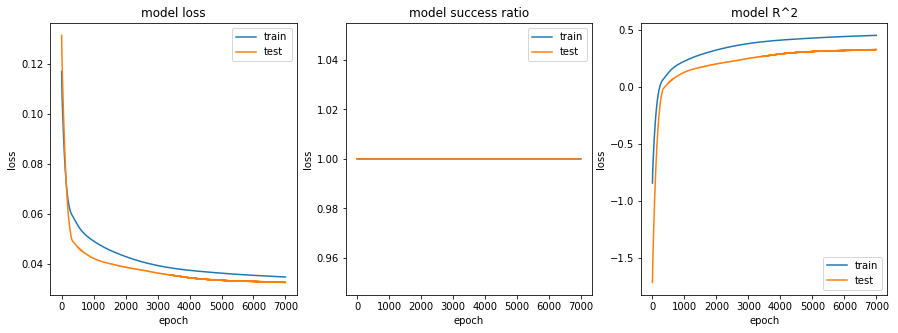

In [19]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [20]:
# make predictions
keras_in_sample = model.predict(train_X).flatten()
keras_out_sample = model.predict(test_X).flatten()
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(train_Y, keras_in_sample))

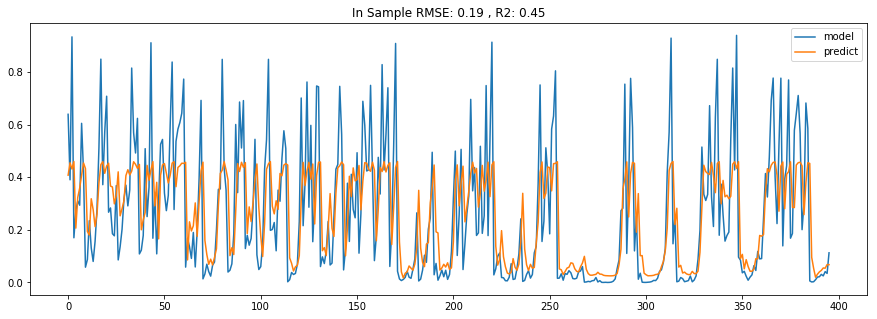

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
plt.title('In Sample RMSE: %.2f , R2: %.2f' % (np.sqrt(mean_squared_error(train_Y, keras_in_sample)), 
                                                  r2_score(train_Y, keras_in_sample)))
plt.legend(loc=0)
plt.show()

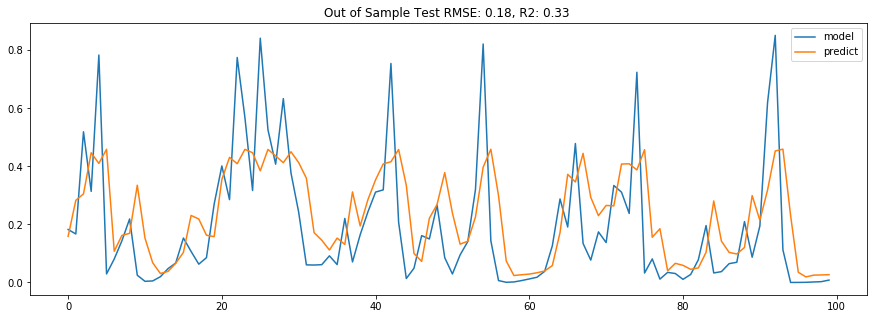

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
plt.title('Out of Sample Test RMSE: %.2f, R2: %.2f ' % (np.sqrt(mean_squared_error(test_Y, keras_out_sample)),
                                              r2_score(test_Y, keras_out_sample)))
plt.legend(loc=0)
plt.show()